# Stacked Autoencoder LSTM

This notebook composed of three big parts after data preprocessing

1. Wavelets Denoising
2.  Stacked Autoencoder
3. LSTM model

In [0]:
!pip install pywavelets

In [0]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DATA_PATH = "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

In [4]:
!ls "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

coin_price_dfs.csv  __MACOSX  orderbook_data.zip  orderbook_dfs.csv


In [0]:
# Unzip Data
# It will take more than 5 min
import zipfile
import io

zf = zipfile.ZipFile(DATA_PATH+"orderbook_data.zip", "r")
zf.extractall(DATA_PATH)

# Data Preprocessing

In [0]:
currency_types = ["btc",'eth']
currency_targets = ["btc"]

TIME_FREQUENCY = 1 # 1, 2, 3, 30 minutes
TIME_SEQ_LEN = 200
FUTURE_PERIOD_PREDICT = 5

# NUM_DEPENDENT_VARIABLE == 2: increase/decrease
# NUM_DEPENDENT_VARIABLE == 3: incrase/no change/decrease
NUM_DEPENDENT_VARIABLE = 3
SIGNIFICANT_CRITERIA = 0.3 # for no change criteria

BATCH_SIZE = 64
NUM_ITERATIONS = 10

TRAIN_RATIO = 0.8

In [11]:
import pandas as pd

# read coin price data
coin_price_dfs = pd.read_csv(DATA_PATH+"coin_price_dfs.csv")
# read orderbeook data
orderbook_dfs = pd.read_csv(DATA_PATH+"orderbook_dfs.csv")    

# sort by timestamp
coin_price_dfs = coin_price_dfs.sort_values(by=['timestamp','currency'])
orderbook_dfs = orderbook_dfs.sort_values(by=['timestamp','currency'])    

# select the columns of interests
coin_price_dfs = coin_price_dfs[coin_price_dfs["currency"].isin(currency_types)]
orderbook_dfs = orderbook_dfs[orderbook_dfs["currency"].isin(currency_types)]

print(coin_price_dfs.shape)
print(orderbook_dfs.shape)

(68456, 15)
(68411, 213)


In [13]:
orderbook_dfs[["timestamp","currency"]].head(n=6)

,timestamp,currency
1,25607915.85,btc
3,25607915.85,eth
8,25607916.85,btc
10,25607916.85,eth
15,25607917.85,btc
17,25607917.85,eth


In [0]:
coinprice_features = ['currency','last','volume','timestamp']

# we only use bid / ask volume data inbetween current price and 3% from it (-3%,-2.9%, =2.8% ...0%, 0.1%, 0.2%... 3%)
bid_cols = ["bid_strength_"+str(i) for i in range(30)]
ask_cols = ["ask_strength_"+str(i) for i in range(30)]
orderbook_features = bid_cols + ask_cols + ["currency","timestamp","bid_ask_spread"]

key_features = coinprice_features + orderbook_features

# merge price and orderbook data based on timestamp
panel_df = pd.merge_asof(left=coin_price_dfs[coinprice_features].reset_index(drop=True), 
                         right=orderbook_dfs[orderbook_features].reset_index(drop=True),
                         on = u'timestamp', by = u'currency')
## interpolation
panel_df = panel_df.groupby('currency').apply(lambda gp: gp.fillna(method="ffill"))

panel_df.dropna(inplace=True)

In [15]:
panel_df[panel_df['currency']=='btc'].head(n=5)

,currency,last,volume,timestamp,bid_strength_0,bid_strength_1,bid_strength_2,bid_strength_3,bid_strength_4,bid_strength_5,...,ask_strength_21,ask_strength_22,ask_strength_23,ask_strength_24,ask_strength_25,ask_strength_26,ask_strength_27,ask_strength_28,ask_strength_29,bid_ask_spread
2,btc,7179000.0,0.1953,2.560792e+07,2.2262,0.5006,5.0065,8.2713,0.0408,1.3164,...,0.0,0.0,0.0,1.0009,6.4400,0.0,0.0,5.5278,0.0005,8000.0
4,btc,7171000.0,1.3128,2.560792e+07,2.2262,4.3329,5.0034,4.3283,0.0408,1.3164,...,0.0,0.0,0.0,1.0009,6.4400,0.0,0.0,5.5278,0.0059,8000.0
6,btc,7171000.0,0.5334,2.560792e+07,5.8373,0.1031,8.8948,0.4727,1.3214,0.2364,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0
8,btc,7171000.0,0.1500,2.560792e+07,6.6385,0.3035,8.8948,0.4727,1.3215,0.2364,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0
10,btc,7178000.0,0.1211,2.560792e+07,6.6385,0.1031,6.9853,0.5867,1.3214,0.0636,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0


In [16]:
# our dataset is not balanced yey
# we need to transform dataframe into (timestamp - coin1 - coin2 - coin3 ...)
new_panel_df_list = []

for currency_type in currency_types:  # begin iteration
  new_col_names = {key_feature:currency_type+"_"+key_feature 
                   for key_feature in key_features if key_feature != "timestamp"}

  single_currency_panel_df = panel_df[panel_df['currency']==currency_type]
  single_currency_panel_df.rename(columns=new_col_names, inplace=True)
  
  print(currency_type, " size: ", single_currency_panel_df.shape[0])    
  new_panel_df_list.append(single_currency_panel_df)

btc  size:  34224
eth  size:  34230


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
balanced_panel_df = new_panel_df_list[0]

for new_panel_df in new_panel_df_list[1:]:
  balanced_panel_df = pd.merge_asof(left=balanced_panel_df.reset_index(drop=True), 
                       right=new_panel_df.reset_index(drop=True),
                       on = u'timestamp')

balanced_panel_df.dropna(inplace=True)    
balanced_panel_df.reset_index(drop=True,inplace=True)

In [20]:
balanced_panel_df[['timestamp','btc_currency','eth_currency']].head().values

array([[25607916.8167, 'btc', 'eth'],
       [25607917.8167, 'btc', 'eth'],
       [25607918.8167, 'btc', 'eth'],
       [25607919.8167, 'btc', 'eth'],
       [25607920.8167, 'btc', 'eth']], dtype=object)

In [0]:
# to create target variable we create return 
for currency_target in currency_targets:
  balanced_panel_df[currency_target+'_last_target'] = balanced_panel_df[currency_target+'_last'].shift(-FUTURE_PERIOD_PREDICT )
  balanced_panel_df[currency_target+'_last_target_return'] = (balanced_panel_df[currency_target+'_last_target'] 
                                                              - balanced_panel_df[currency_target+'_last'])/balanced_panel_df[currency_target+'_last']

In [0]:
def classify_trinary(values):
  gp_std = np.std(values)

  target = []
  for value in values:
    if SIGNIFICANT_CRITERIA*gp_std < value:
      target.append(2)
    elif -SIGNIFICANT_CRITERIA*gp_std > value:
      target.append(0)  
    else:
      target.append(1)  

  return target

In [0]:
import numpy as np

for currency_target in currency_targets:
  if NUM_DEPENDENT_VARIABLE == 2:
    print("NUM_DEPENDENT_VARIABLE: ", 2)
    balanced_panel_df[currency_target+'_target'] = balanced_panel_df[currency_target+'_last_target_return'].apply(lambda x: 0 if x <= 0 else 1)

  elif NUM_DEPENDENT_VARIABLE == 3:    
    print("NUM_DEPENDENT_VARIABLE: ", 3)
    print("SIGNIFICANT_CRITERIA:", SIGNIFICANT_CRITERIA)
    balanced_panel_df[currency_target+'_target'] = balanced_panel_df[currency_target+"_last_target_return"].transform(classify_trinary)    

  else:
    print("NUM_DEPENDENT_VARIABLE is not properly specified")

In [0]:
# we scaled input data using mix max scaler
from sklearn import preprocessing 

exclude_cols = [] # if you want to ignore some columns for mix max scaling, write the column here
exceptions = ["currency", "timestamp", "target"]

for col in balanced_panel_df.columns:
  exception_occur = False

  for exception in exceptions:
    if exception in col:
      exception_occur = True
      exclude_cols.append(col)

  if exception_occur:
    continue
  
  balanced_panel_df[col] = preprocessing.minmax_scale(balanced_panel_df[col].values)

In [0]:
# we sholud exclude these variable
# since we should not predict based on the future information
target_cols = [currency_target+"_target" for currency_target in currency_targets]

for target_col in target_cols:
    exclude_cols.remove(target_col) 

balanced_panel_df = balanced_panel_df.filter(regex="^(?!({0})$).*$".format('|'.join(exclude_cols)))

In [0]:
# split train test dataset
panel_df_train = balanced_panel_df.iloc[:int(balanced_panel_df.shape[0]*TRAIN_RATIO)]
panel_df_test = balanced_panel_df[~balanced_panel_df.index.isin(panel_df_train.index)]

# 1. Wavelets Denoising

At this part, I denoise input values with haar wavelets denoising method

Input values are a bit different from paper (A Deep Learning Framework for Financial Time Series using Stacked Autoencoders and Long-Short Term Memory)

I use orderbook data, various coin price and volume as input values instead of technical indicators or macro economic variables which might be unrelated with coin data



In [0]:
import random
from collections import deque
import pywt
import numpy as np

def sequence_generator(panel_df, TIME_SEQ_LEN, suffle=True,seed=101):

  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = TIME_SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in panel_df.values:  # iterate over the values
    queue.append([n for n in i[:-1]])  # store all but the target
    if len(queue) == TIME_SEQ_LEN:  # make sure we have 60 sequences!
      
      # wavelets denoising
      x = np.array(queue)
      (ca, cd) = pywt.dwt(x, "haar")
      cat = pywt.threshold(ca, np.std(ca), mode="soft")
      cdt = pywt.threshold(cd, np.std(cd), mode="soft")
      tx = pywt.idwt(cat, cdt, "haar")
      
      sequential_data.append([tx, i[-1]])  # append those bad boys!
      
  if suffle == True:
    random.seed(seed)
    random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
train_X, train_Y = sequence_generator(panel_df_train , TIME_SEQ_LEN, suffle=True, seed=101)
test_X, test_Y = sequence_generator(panel_df_test, TIME_SEQ_LEN, suffle=False)

In [0]:
print(panel_df_train.shape)
print(train_X.shape)
print(len(train_Y))

print(panel_df_test.shape)
print(test_X.shape)
print(len(test_Y))

# 2.  Stacked Autoencoder
At this part, we use input values as price, volume and orderbook data for autoencoding

It's a little bit different from out previous stacked autoencoders who generate prices only

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers


def autoencoder_model(input_dim, output_dim):

  L1 = 40 
  L2 = 30
  L3 = 20  
  L4 = 30 
  L5 = 40

  input_seq = Input(shape=input_dim)
  encoded = Dense(L1, activation='relu', activity_regularizer=regularizers.l2(0))(input_seq)
  encoded = Dense(L2, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)
  encoded = Dense(L3, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)

  decoded = Dense(L4, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)
  decoded = Dense(L5, activation='relu', activity_regularizer=regularizers.l2(0))(decoded)
  decoded = Dense(output_dim, activation='linear')(decoded)  

  autoencoder = Model(input_seq, decoded)
  autoencoder.compile(optimizer='rmsprop', loss='mse', metrics=['acc', 'cosine_proximity'])
  autoencoder.summary()
  
  encoder = Model(input_seq, encoded)
  
  return encoder, autoencoder

In [0]:
encoder, autoencoder = autoencoder_model(train_X.shape[1:], train_X.shape[2])

In [0]:
BATCH_SIZE = 64
NUM_ITERATIONS = 100


encoder_hist = autoencoder.fit(train_X, train_X, 
                        batch_size = BATCH_SIZE,
                        validation_split=0.2,
                        epochs = NUM_ITERATIONS)

In [0]:
import matplotlib.pyplot as plt

plt.title('model loss')
legend_names = []
# summarize history for accuracy
plt.plot(encoder_hist.history['loss'])
plt.plot(encoder_hist.history['val_loss'])
legend_names.extend(['train', 'validation'])

plt.legend(legend_names, loc='upper left')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# we use encoded values as input values of LSTM
encoded_train_X = encoder.predict(train_X)
encoded_test_X = encoder.predict(test_X)

# 3. LSTM model


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Flatten
from tensorflow.keras.layers import Activation

def rnn_model(input_dim, output_dim):
    
  # you can try your own model!

  L1 = 256  # 256

  model = Sequential()
  
  model.add(CuDNNLSTM(L1, input_shape=input_dim, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

  model.add(Flatten())
  model.add(Dense(output_dim))
  model.add(Activation('softmax'))

  model.compile(optimizer=tf.train.AdamOptimizer(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])


  return model

In [0]:
rnn_model = rnn_model(encoded_train_X.shape[1:], NUM_DEPENDENT_VARIABLE)

In [0]:
BATCH_SIZE = 64
NUM_ITERATIONS = 10

rnn_hist = rnn_model.fit(encoded_train_X, tf.keras.utils.to_categorical(train_Y, num_classes=None), 
                            batch_size = BATCH_SIZE,
                            validation_split=0.2,
                            epochs = NUM_ITERATIONS)

Train on 21744 samples, validate on 5436 samples
Epoch 1/10
21744/21744 [==============================] - 26s 1ms/step - loss: 1.9040 - acc: 0.3392 - val_loss: 1.2302 - val_acc: 0.3144
Epoch 2/10
21744/21744 [==============================] - 25s 1ms/step - loss: 1.7198 - acc: 0.3383 - val_loss: 1.1326 - val_acc: 0.3670
Epoch 3/10
21744/21744 [==============================] - 25s 1ms/step - loss: 1.4470 - acc: 0.3437 - val_loss: 1.1267 - val_acc: 0.3324
Epoch 4/10
21744/21744 [==============================] - 25s 1ms/step - loss: 1.2593 - acc: 0.3439 - val_loss: 1.1303 - val_acc: 0.3355
Epoch 5/10
21744/21744 [==============================] - 24s 1ms/step - loss: 1.1640 - acc: 0.3634 - val_loss: 1.1409 - val_acc: 0.3753
Epoch 6/10
21744/21744 [==============================] - 25s 1ms/step - loss: 1.1146 - acc: 0.3787 - val_loss: 1.1204 - val_acc: 0.3777
Epoch 7/10
21744/21744 [==============================] - 25s 1ms/step - loss: 1.0866 - acc: 0.4026 - val_loss: 1.1359 - val_acc:

# Evaluation

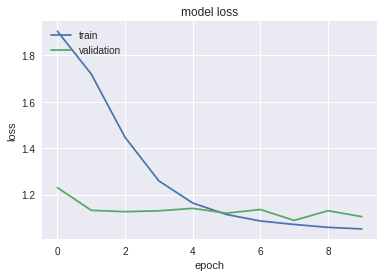

In [0]:
import matplotlib.pyplot as plt

plt.title('model loss')
legend_names = []
# summarize history for accuracy
plt.plot(rnn_hist.history['loss'])
plt.plot(rnn_hist.history['val_loss'])
legend_names.extend(['train', 'validation'])

plt.legend(legend_names, loc='upper left')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
predictions = rnn_model.predict_classes(encoded_test_X)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(predictions, test_Y))

             precision    recall  f1-score   support

          0       0.59      0.30      0.39      3828
          1       0.11      0.42      0.18       756
          2       0.31      0.29      0.30      2062

avg / total       0.45      0.31      0.34      6646



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


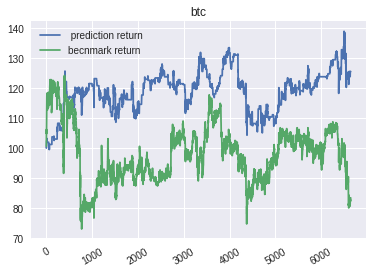

In [0]:
bechmark_return = 100
bechmark_return_history = []

prediction_return = 100
prediction_return_history = []

buy_price = 0
sell_price = 0

hold = False

panel_df_test[currency_target+'_last_return'] = panel_df_test[currency_target+'_last'].pct_change()

for prediction, (i, r) in zip(predictions, panel_df_test.iloc[TIME_SEQ_LEN-1:].iterrows()):

    if hold == True:
        prediction_return = prediction_return*(1+r[currency_target+'_last_return'])  

    bechmark_return = bechmark_return*(1+r[currency_target+'_last_return'])
    bechmark_return_history.append(bechmark_return)
    prediction_return_history.append(prediction_return)

    if prediction ==2:
        hold = True
    else: 
        hold = False

plt.title(currency_target)
plt.plot(prediction_return_history, label = ' prediction return')    
plt.plot(bechmark_return_history, label = 'becnmark return')
plt.xticks(rotation=30)
plt.legend()
plt.show()